In [22]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)
import matplotlib.pyplot as plt
import joblib

In [23]:
# Load datasets
train_df = pd.read_csv("churn-bigml-80.csv")
test_df  = pd.read_csv("churn-bigml-20.csv")

In [15]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (2666, 20)
Test shape: (667, 20)


In [24]:
# To ensure target is numeric 0/1
train_df['Churn'] = train_df['Churn'].astype(int)
test_df['Churn']  = test_df['Churn'].astype(int)

In [25]:
# Split features/target
X_train_df = train_df.drop("Churn", axis=1)
y_train = train_df["Churn"]
X_test_df  = test_df.drop("Churn", axis=1)
y_test = test_df["Churn"]

In [ ]:
# To detect categorical columns (object dtype OR low-cardinality ints)
cat_cols = list(X_train_df.select_dtypes(include=['object']).columns)
for col in X_train_df.columns:
    if X_train_df[col].dtype in ['int64','int32'] and X_train_df[col].nunique() <= 10 and col not in cat_cols:
        cat_cols.append(col)

In [26]:
# To ensure common churn fields are treated as categorical
for c in ["State", "Area code", "International plan", "Voice mail plan", "Customer service calls"]:
    if c in X_train_df.columns and c not in cat_cols:
        cat_cols.append(c)

num_cols = [c for c in X_train_df.columns if c not in cat_cols]

In [27]:
# Preprocessor (fit on train only)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='drop')

X_train = preprocessor.fit_transform(X_train_df)
X_test  = preprocessor.transform(X_test_df)

In [28]:
# Model
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [29]:
# 6. Predict + Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1:", f1_score(y_test, y_pred, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8125937031484258
Precision: 0.4166666666666667
Recall: 0.7894736842105263
F1: 0.5454545454545454
ROC AUC: 0.8490062569009937

Confusion matrix:
 [[467 105]
 [ 20  75]]

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.82      0.88       572
           1       0.42      0.79      0.55        95

    accuracy                           0.81       667
   macro avg       0.69      0.80      0.71       667
weighted avg       0.88      0.81      0.83       667



In [31]:
# Coefficients -> odds ratios
num_feature_names = num_cols
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_feature_names + cat_feature_names

coefs = model.coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({"feature":feature_names, "coef":coefs, "odds_ratio":odds}).sort_values("odds_ratio", ascending=False)
print("\nTop 10 features increasing odds of churn:")
print(coef_df.head(10).to_string(index=False))
print("\nTop 10 features decreasing odds of churn:")
print(coef_df.tail(10).to_string(index=False))


Top 10 features increasing odds of churn:
                 feature     coef  odds_ratio
Customer service calls_5 3.405297   30.123242
Customer service calls_6 3.075842   21.668117
Customer service calls_4 2.973384   19.558001
Customer service calls_7 2.960893   19.315210
  International plan_Yes 2.474932   11.880896
Customer service calls_8 1.373381    3.948680
                State_MT 1.025608    2.788790
                State_MS 1.006261    2.735356
                State_TX 0.931605    2.538579
                State_NJ 0.814505    2.258057

Top 10 features decreasing odds of churn:
            feature      coef  odds_ratio
           State_WV -0.408299    0.664780
           State_MO -0.418880    0.657783
           State_AL -0.447103    0.639478
           State_WI -0.593537    0.552370
           State_IA -0.606968    0.545001
           State_VA -0.804780    0.447186
           State_IL -1.020994    0.360237
           State_HI -1.092524    0.335369
           State_RI -1.310348 

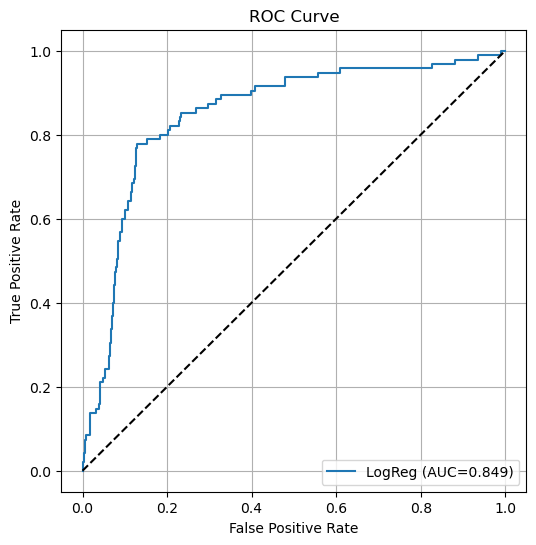

In [32]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'LogReg (AUC={roc_auc_score(y_test,y_proba):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [33]:
# 9. Save artifacts
joblib.dump(model, "churn_logreg_model.joblib")
joblib.dump(preprocessor, "churn_preprocessor.joblib")

['churn_preprocessor.joblib']